In [1]:
# Majoni Maumbe
# Version 1.3 created 11/31/2018 by Majoni Maumbe
# import packages for analysis and modeling

import pandas as pd  # data frame operations
import csv
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
import re
import decimal
D = decimal.Decimal

# read in data and create data frame
csv1 = pd.read_csv("data/Zip_Zhvi_SingleFamilyResidence.csv", dtype=None)
print(csv1[csv1['RegionName']==72102])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


       RegionID  RegionName   City State   Metro CountyName  SizeRank  \
12270     89370       72102  McRae    AR  Searcy      White     12271   

       1996-04  1996-05  1996-06   ...     2017-06  2017-07  2017-08  2017-09  \
12270      NaN      NaN      NaN   ...       72582    72720    72948    72650   

       2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  
12270    71994    71545    70987    70739    70805    70954  

[1 rows x 271 columns]


In [2]:
# Clean data - replace nulls with zeros
csv2 = csv1.dropna()
print(csv2[csv2['RegionName']==72102])
csv2.to_csv("data/Zillow_less.csv", sep=',')
print(len(csv1.RegionName))
print(len(csv2.RegionName))

Empty DataFrame
Columns: [RegionID, RegionName, City, State, Metro, CountyName, SizeRank, 1996-04, 1996-05, 1996-06, 1996-07, 1996-08, 1996-09, 1996-10, 1996-11, 1996-12, 1997-01, 1997-02, 1997-03, 1997-04, 1997-05, 1997-06, 1997-07, 1997-08, 1997-09, 1997-10, 1997-11, 1997-12, 1998-01, 1998-02, 1998-03, 1998-04, 1998-05, 1998-06, 1998-07, 1998-08, 1998-09, 1998-10, 1998-11, 1998-12, 1999-01, 1999-02, 1999-03, 1999-04, 1999-05, 1999-06, 1999-07, 1999-08, 1999-09, 1999-10, 1999-11, 1999-12, 2000-01, 2000-02, 2000-03, 2000-04, 2000-05, 2000-06, 2000-07, 2000-08, 2000-09, 2000-10, 2000-11, 2000-12, 2001-01, 2001-02, 2001-03, 2001-04, 2001-05, 2001-06, 2001-07, 2001-08, 2001-09, 2001-10, 2001-11, 2001-12, 2002-01, 2002-02, 2002-03, 2002-04, 2002-05, 2002-06, 2002-07, 2002-08, 2002-09, 2002-10, 2002-11, 2002-12, 2003-01, 2003-02, 2003-03, 2003-04, 2003-05, 2003-06, 2003-07, 2003-08, 2003-09, 2003-10, 2003-11, 2003-12, ...]
Index: []

[0 rows x 271 columns]
14602
9835


In [3]:
#Create Data Frame and get the mean Prices for houses per state
df0 = csv2.groupby(["State", "RegionName"])["2018-03"].mean().reset_index(name="Mean-Price")
print(df0.head())
df = csv2.groupby(["State"])["2018-03"].mean().reset_index(name="Mean-Price")
print(df.tail())

  State  RegionName  Mean-Price
0    AK       99501      385951
1    AK       99502      354339
2    AK       99503      311210
3    AK       99504      325574
4    AK       99507      365390
   State     Mean-Price
43    VA  327001.469314
44    VT  200335.968750
45    WA  455842.088710
46    WI  199738.088123
47    WV  113999.687500


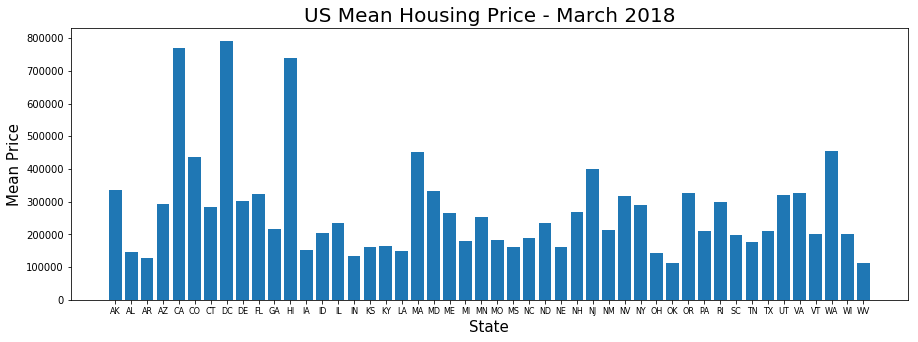

In [4]:
#Bar Graph for all Mean housing prices for all the states
plt.figure(figsize=(15,5))
index = np.arange(len(df))
prices = df['Mean-Price'].values
plt.bar(index, prices)
plt.xlabel('State', fontsize=15)
plt.xticks(index, df['State'], fontsize=8, rotation=0)
plt.ylabel('Mean Price', fontsize=15)
plt.title('US Mean Housing Price - March 2018', fontsize = 20)
plt.show()

In [5]:
#DataFrame for the Median house Prices for all the States
df0 = csv2.groupby(["State", "RegionName"])["2018-03"].median().reset_index(name="Median-Price")
print(df0.head())
df = csv2.groupby(["State"])["2018-03"].median().reset_index(name="Median-Price")
print(df.tail())

  State  RegionName  Median-Price
0    AK       99501        385951
1    AK       99502        354339
2    AK       99503        311210
3    AK       99504        325574
4    AK       99507        365390
   State  Median-Price
43    VA      251173.0
44    VT      181526.0
45    WA      363758.5
46    WI      181170.0
47    WV      112618.0


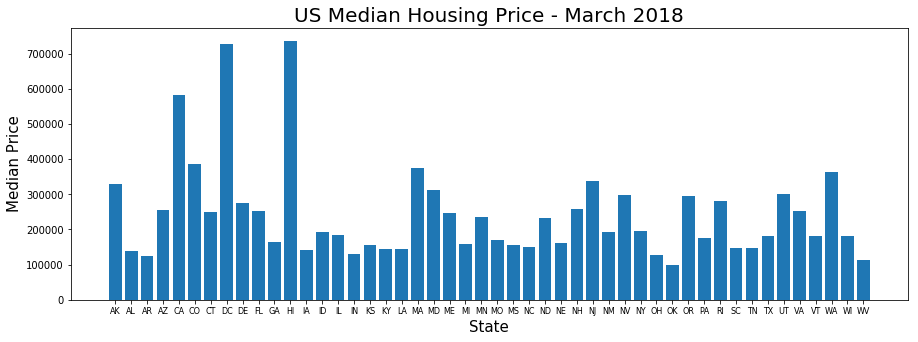

In [6]:
#Bar graph for all the Median Housing Prices for all the States
plt.figure(figsize=(15,5))
index = np.arange(len(df))
prices = df['Median-Price'].values
plt.bar(index, prices)
plt.xlabel('State', fontsize=15)
plt.xticks(index, df['State'], fontsize=8, rotation=0)
plt.ylabel('Median Price', fontsize=15)
plt.title('US Median Housing Price - March 2018', fontsize = 20)
plt.show()

In [7]:
#Developing a model for forecasting average median housing values
# I have selected 3 zipcodes in Maryland where I want to invest in the future
#20854
#20814
#20817
# I will be Modelling at the Zip Code Level Using ARIMA Model

import warnings
import numpy
from pandas import Series

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from math import sqrt
from pandas import DataFrame
from scipy.stats import boxcox

#FIRST ZIP CODE 20854

df_20854 = csv2.query("RegionName=='20854'")
df = df_20854.drop(df_20854.columns[[0,1,2,3,4,5,6]], axis=1) 
df_20854_m = df.mean()
df_20854_m.to_csv('data/Zillow_20854.csv', sep=',')
series = Series.from_csv('data/Zillow_20854.csv')
series_train = series.ix['1997-01-01':'2013-12-31']
series_test = series.ix['2014-01-01':'2014-03-31']

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	# X = X.astype('float32')
	train = series.ix['1997-01-01':'2013-12-31']
	test = series.ix['2014-01-01':'2014-03-31']
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		periods = 12
		diff = difference(history, periods)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, periods)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	return(best_cfg, best_score)
 
# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
best_cfg, best_score = evaluate_models(series.values, p_values, d_values, q_values)
print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


ARIMA(0, 0, 1) RMSE=10709.131
ARIMA(0, 1, 1) RMSE=3400.274
ARIMA(0, 2, 1) RMSE=2690.217
ARIMA(1, 0, 0) RMSE=6024.690
ARIMA(1, 1, 0) RMSE=2263.516
ARIMA(1, 1, 1) RMSE=2544.620
ARIMA(1, 2, 0) RMSE=2207.881
ARIMA(1, 2, 1) RMSE=2885.591
ARIMA(2, 0, 1) RMSE=2491.551
ARIMA(2, 1, 0) RMSE=2628.420
ARIMA(2, 1, 1) RMSE=2982.780
ARIMA(2, 2, 0) RMSE=3038.160
ARIMA(2, 2, 1) RMSE=3221.252
ARIMA(3, 0, 1) RMSE=2921.734
ARIMA(3, 1, 0) RMSE=3053.640
ARIMA(3, 1, 1) RMSE=3177.582
ARIMA(3, 2, 0) RMSE=3129.332
ARIMA(3, 2, 1) RMSE=3224.186
Best ARIMA(1, 2, 0) RMSE=2207.881


In [8]:
# Zip Code 20854 - CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING ONE STEP AHEAD
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# prepare data
X = series.values
# X = X.astype('float32')
# difference data
periods = 5
diff = difference(X, periods)
# fit model
model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual - CHANGED TO ZERO
bias = 0
# save model
model_fit.save('data/model_Z20854.pkl')
numpy.save('data/model_bias_Z20854.npy', [bias])

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

periods = 5
model_fit = ARIMAResults.load('data/model_Z20854.pkl')
bias = numpy.load('data/model_bias_Z20854.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, periods)
print('Predicted: %.3f' % yhat)

Predicted: 893830.470


In [9]:
# Zip Code 20854 - CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING MANY STEPS AHEAD
series = Series.from_csv('data/Zillow_20854.csv')
# prepare data
X = series.values
#X = X.astype('float32')
#train_size = int(len(X) * 0.50)
#train, test = X[0:train_size], X[train_size:]
train = series.ix['1997-01-01':'2013-12-31']
test = series.ix['2014-01-01':'2014-03-31']
# walk-forward validation
history = [x for x in train]
print(type(history[0]))

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load and prepare datasets
dataset = train
# X = dataset.values.astype('float32')
history = [x for x in X]
periods = 60
validation = test
y = validation.values     #.astype('float32')
# load model
model_fit = ARIMAResults.load('data/model_Z20854.pkl')
bias = numpy.load('data/model_bias_Z20854.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, periods)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	periods = 50
	diff = difference(history, periods)
	# predict
	model = ARIMA(diff, order=best_cfg)
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, periods)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)


<class 'float'>
>Predicted=857269.470, Expected=859214
>Predicted=810646.949, Expected=859411
>Predicted=853796.714, Expected=859092
RMSE: 28341.688


In [10]:
# SECOND ZIP CODE 20814 

df_20814 = csv2.query("RegionName=='20814'")
df = df_20814.drop(df_20814.columns[[0,1,2,3,4,5,6]], axis=1) 
df_20814_m = df.mean()
df_20814_m.to_csv("data/Zillow_20814.csv", sep=',')

series = Series.from_csv('data/Zillow_20814.csv')
# prepare data
X = series.values
#X = X.astype('float32')
#train_size = int(len(X) * 0.50)
#train, test = X[0:train_size], X[train_size:]
train = series.ix['1997-01-01':'2013-12-31']
test = series.ix['2014-01-01':'2014-03-31']
# walk-forward validation
history = [x for x in train]
print(type(history[0]))
import warnings
import numpy
 
 # create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	# X = X.astype('float32')
	train = series.ix['1997-01-01':'2013-12-31']
	test = series.ix['2014-01-01':'2014-03-31']
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		periods = 12
		diff = difference(history, periods)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, periods)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	return(best_cfg, best_score)
 
# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
best_cfg, best_score = evaluate_models(series.values, p_values, d_values, q_values)
print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

<class 'float'>
ARIMA(0, 0, 1) RMSE=22336.795
ARIMA(0, 1, 1) RMSE=1312.779
ARIMA(0, 2, 1) RMSE=2159.067
ARIMA(1, 0, 0) RMSE=1919.214
ARIMA(1, 1, 0) RMSE=1289.530
ARIMA(1, 1, 1) RMSE=1892.051
ARIMA(1, 2, 0) RMSE=1532.959
ARIMA(1, 2, 1) RMSE=2218.461
ARIMA(2, 0, 1) RMSE=1878.760
ARIMA(2, 1, 0) RMSE=1612.433
ARIMA(2, 1, 1) RMSE=2179.813
ARIMA(2, 2, 0) RMSE=2393.653
ARIMA(2, 2, 1) RMSE=2625.071
ARIMA(3, 0, 1) RMSE=2161.732
ARIMA(3, 1, 0) RMSE=2260.202
ARIMA(3, 1, 1) RMSE=2457.995
ARIMA(3, 2, 0) RMSE=2571.139
ARIMA(3, 2, 1) RMSE=2638.117
Best ARIMA(1, 1, 0) RMSE=1289.530


In [11]:
# Zip Code 20814 - CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING ONE STEP AHEAD

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

periods = 5
model_fit = ARIMAResults.load('data/model_Z20814.pkl')
bias = numpy.load('data/model_bias_Z20814.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, periods)
print('Predicted: %.3f' % yhat)

Predicted: 880702.975


In [12]:
# Zip Code 20814 - CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING MANY STEPS AHEAD

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load and prepare datasets
dataset = train
# X = dataset.values.astype('float32')
history = [x for x in X]
periods = 50
validation = test
y = validation.values     #.astype('float32')
# load model
model_fit = ARIMAResults.load('data/model_Z20814.pkl')
bias = numpy.load('data/model_bias_Z20814.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, periods)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	periods = 50
	diff = difference(history, periods)
	# predict
	model = ARIMA(diff, order=best_cfg)
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, periods)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)


>Predicted=814185.975, Expected=801886
>Predicted=721093.445, Expected=802240
>Predicted=802886.900, Expected=804317
RMSE: 47392.327


In [13]:
# THIRD ZIP CODE 20817 

df_20817 = csv2.query("RegionName=='20817'")
df = df_20817.drop(df_20817.columns[[0,1,2,3,4,5,6]], axis=1) 
df_20817_m = df.mean()
df_20817_m.to_csv("data/Zillow_20817.csv", sep=',')

series = Series.from_csv('data/Zillow_20817.csv')
# prepare data
X = series.values
#X = X.astype('float32')
#train_size = int(len(X) * 0.50)
#train, test = X[0:train_size], X[train_size:]
train = series.ix['1997-01-01':'2013-12-31']
test = series.ix['2014-01-01':'2014-03-31']
# walk-forward validation
history = [x for x in train]
print(type(history[0]))

# Zip Code 20817 - CODE RUNS LONG FOR EVALUATION - approximately 
import warnings
import numpy
 
 # create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	# X = X.astype('float32')
	train = series.ix['1997-01-01':'2013-12-31']
	test = series.ix['2014-01-01':'2014-03-31']
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		periods = 12
		diff = difference(history, periods)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, periods)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	return(best_cfg, best_score)
 
# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
best_cfg, best_score = evaluate_models(series.values, p_values, d_values, q_values)
print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))



<class 'float'>
ARIMA(0, 0, 1) RMSE=26433.416
ARIMA(0, 1, 1) RMSE=1722.689
ARIMA(0, 2, 1) RMSE=2441.433
ARIMA(1, 0, 0) RMSE=3437.399
ARIMA(1, 1, 0) RMSE=3373.630
ARIMA(1, 1, 1) RMSE=1918.615
ARIMA(1, 2, 0) RMSE=3616.392
ARIMA(1, 2, 1) RMSE=2454.954
ARIMA(2, 0, 1) RMSE=1888.249
ARIMA(2, 1, 0) RMSE=2951.074
ARIMA(2, 1, 1) RMSE=1989.701
ARIMA(2, 2, 0) RMSE=2230.572
ARIMA(2, 2, 1) RMSE=1984.475
ARIMA(3, 0, 1) RMSE=1957.549
ARIMA(3, 1, 0) RMSE=2141.606
ARIMA(3, 1, 1) RMSE=1838.152
ARIMA(3, 2, 0) RMSE=2089.213
ARIMA(3, 2, 1) RMSE=1986.246
Best ARIMA(0, 1, 1) RMSE=1722.689


In [14]:
# Zip Code 20817 - CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING ONE STEP AHEAD

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

periods = 5
model_fit = ARIMAResults.load('data/model_Z20817.pkl')
bias = numpy.load('data/model_bias_Z20817.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, periods)
print('Predicted: %.3f' % yhat)

Predicted: 909313.975


In [15]:
# Zip Code 20817 - CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING MANY STEPS AHEAD

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load and prepare datasets
dataset = train
# X = dataset.values.astype('float32')
history = [x for x in X]
periods = 50
validation = test
y = validation.values     #.astype('float32')
# load model
model_fit = ARIMAResults.load('data/model_Z20817.pkl')
bias = numpy.load('data/model_bias_Z20817.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, periods)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	periods = 50
	diff = difference(history, periods)
	# predict
	model = ARIMA(diff, order=best_cfg)
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, periods)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)


>Predicted=874790.975, Expected=858447
>Predicted=815439.109, Expected=862845
>Predicted=894464.132, Expected=867819
RMSE: 32784.179
